Please answer completely all four required questions (250 Points).

### Question 1: Load (50 Points)

- Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found as transactions.txt (above attached)

- Please describe the structure of the data. Number of records and fields in each record?

- Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
df = pd.read_json('transactions.txt', lines=True)

In [4]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [5]:
print("Dataset Overview:")
print(f"Number of records: {len(df):,}")
print(f"Number of fields: {len(df.columns)}")
print("\nData Types:")
print(df.dtypes)

Dataset Overview:
Number of records: 786,363
Number of fields: 29

Data Types:
accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises        

In [6]:
num_records = len(df)
print(f"Number of records: {num_records:,}")

Number of records: 786,363


In [7]:
num_fields = len(df.columns)
print(f"Number of fields in each record: {num_fields}")
print(f"Fields: {', '.join(df.columns)}")

Number of fields in each record: 29
Fields: accountNumber, customerId, creditLimit, availableMoney, transactionDateTime, transactionAmount, merchantName, acqCountry, merchantCountryCode, posEntryMode, posConditionCode, merchantCategoryCode, currentExpDate, accountOpenDate, dateOfLastAddressChange, cardCVV, enteredCVV, cardLast4Digits, transactionType, echoBuffer, currentBalance, merchantCity, merchantState, merchantZip, cardPresent, posOnPremises, recurringAuthInd, expirationDateKeyInMatch, isFraud


In [8]:
# Statistics
print("\nSummary statistics:")
for column in df.columns:
    print(f"\nField: {column}")
    # Null values
    null_count = df[column].isnull().sum()
    print(f"  Null count: {null_count}")
    
    # Unique values
    unique_count = df[column].nunique()
    print(f"  Unique values: {unique_count}")
    
    # Min and max
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"  Min: {df[column].min()}")
        print(f"  Max: {df[column].max()}")
        print(f"  Mean: {df[column].mean()}")
    
    # If its a string field then min and max length
    elif pd.api.types.is_string_dtype(df[column]):
        if null_count < len(df): 
            # Length
            lengths = df[column].dropna().astype(str).apply(len)
            if not lengths.empty:
                print(f"  Min length: {lengths.min()}")
                print(f"  Max length: {lengths.max()}")
    

    if unique_count < 20 and unique_count > 0:
        sample_values = df[column].dropna().unique()[:5]  # Get first 5 unique values
        print(f"  Sample values: {', '.join(map(str, sample_values))}")



Summary statistics:

Field: accountNumber
  Null count: 0
  Unique values: 5000
  Min: 100088067
  Max: 999389635
  Mean: 537232599.4617028

Field: customerId
  Null count: 0
  Unique values: 5000
  Min: 100088067
  Max: 999389635
  Mean: 537232599.4617028

Field: creditLimit
  Null count: 0
  Unique values: 10
  Min: 250
  Max: 50000
  Mean: 10759.464458526152
  Sample values: 5000, 2500, 50000, 15000, 10000

Field: availableMoney
  Null count: 0
  Unique values: 521915
  Min: -1005.63
  Max: 50000.0
  Mean: 6250.725369288736

Field: transactionDateTime
  Null count: 0
  Unique values: 776637
  Min length: 19
  Max length: 19

Field: transactionAmount
  Null count: 0
  Unique values: 66038
  Min: 0.0
  Max: 2011.54
  Mean: 136.98579095150708

Field: merchantName
  Null count: 0
  Unique values: 2490
  Min length: 4
  Max length: 30

Field: acqCountry
  Null count: 0
  Unique values: 5
  Min length: 0
  Max length: 3
  Sample values: US, , CAN, MEX, PR

Field: merchantCountryCode
  Nu

### Question 2: Plot (25 Points)

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

- Report any structure you find and any hypotheses you have about that structure.

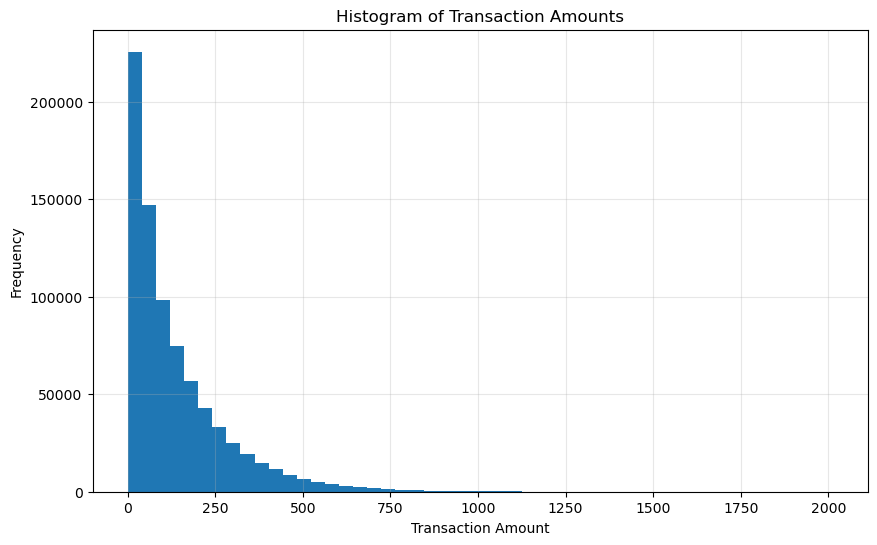

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df['transactionAmount'], bins=50)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

_The histogram shows a strong positive skew with a high concentration of transactions at values under $250 and a long tail extending to around $2,000._

_The frequency of transactions declimes exponentially as the transaction amount increases. The highest frequency bar is at the lowest end, indicating that very small transactions are the most common. There appears to be a primary concentration zone under $250, and then a more gradual decline in frequency for transactions between $250-750. Transactions above $750 are relatively rare, making up only a small percentage of the overall dataset._

_The distribution represents different categories of transactions, with everyday small purchases dominating the lower end and occasional larger purchases forming the tail. This pattern is consistent with typical consumer spending behavior. The gradual decrease in frequency might indicate consumer behavior changes like more deliberation for purchases above certain amounts._

_If this data comes from a specific business, the distribution suggests a business model focused on high-volume, lower-value transactions. The extreme values in the tail might be worth investigating for potential anomalies. It can be applied to the data a logarithmic transformation to normalize the distribution._

### Question 3: Data Wrangling - Duplicate Transactions (75 Points)

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

- Can you programmatically identify reversed and multi-swipe transactions?

- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts).

- Did you find anything interesting about either kind of transaction?


In [17]:
# Reversed transactions
def identify_reversed_transactions(transactions_df):
    df_copy = transactions_df.copy()
    
    if 'accountNumber' not in df_copy.columns:
        raise ValueError("accountNumber not found in the dataset")
    
    if 'transactionAmount' not in df_copy.columns:
        raise ValueError("transactionAmount field not found in the dataset")
    
    if 'transactionDateTime' not in df_copy.columns:
        raise ValueError("transactionDateTime field not found in the dataset")
    
    # Sorting by account and transaction datetime
    df_copy = df_copy.sort_values(['accountNumber', 'transactionDateTime'])
    
    # Unique ID per transaction
    df_copy['transaction_id'] = range(len(df_copy))
    
    #Sshifted dataframe to compare consecutive transactions
    df_shifted = df_copy.shift(-1)
    
    # 3 days is common in banking for time reversals
    time_threshold = pd.Timedelta(days=3)
    
    # Potential reversals: same account, opposite amount and close in time.
    reversals = (
        (df_copy['accountNumber'] == df_shifted['accountNumber']) &
        (df_copy['transactionAmount'] == -df_shifted['transactionAmount']) &
        ((df_shifted['transactionDateTime'] - df_copy['transactionDateTime']) <= time_threshold)
    )
    
    # Original transactions and their reversals
    original_txns = df_copy[reversals].copy()
    reversal_txns = df_copy.shift(-1)[reversals].copy()
    
    # Reversal pairs
    reversal_pairs = pd.DataFrame({
        'original_id': original_txns['transaction_id'].values,
        'reversal_id': reversal_txns['transaction_id'].values,
        'accountNumber': original_txns['accountNumber'].values,
        'original_amount': original_txns['transactionAmount'].values,
        'reversal_amount': reversal_txns['transactionAmount'].values,
        'original_datetime': original_txns['transactionDateTime'].values,
        'reversal_datetime': reversal_txns['transactionDateTime'].values,
        'time_difference': reversal_txns['transactionDateTime'].values - original_txns['transactionDateTime'].values
    })
    
    # Reversal flags to the original dataframe
    df_copy['is_reversal_pair'] = False
    df_copy.loc[df_copy['transaction_id'].isin(original_txns['transaction_id']), 'is_reversal_pair'] = True
    df_copy.loc[df_copy['transaction_id'].isin(reversal_txns['transaction_id']), 'is_reversal_pair'] = True
    
    df_copy['is_original_txn'] = df_copy['transaction_id'].isin(original_txns['transaction_id'])
    df_copy['is_reversal_txn'] = df_copy['transaction_id'].isin(reversal_txns['transaction_id'])
    
    return df_copy, reversal_pairs

In [19]:
# Multi-swipe transactions
def identify_multi_swipes(transactions_df, time_threshold_minutes=10, amount_threshold=0.01):
    """
    Mmulti-swipe transactions based on the same account, same merchant, similar amount and close timestamp.
    
    Parameters:
    - transactions_df: DataFrame containing transaction data
    - time_threshold_minutes: Maximum time difference between transactions to be considered multi-swipes
    - amount_threshold: Maximum proportional difference in amount to be considered similar
    """
    df_copy = transactions_df.copy()
    
    if 'accountNumber' not in df_copy.columns:
        raise ValueError("accountNumber not found in the dataset")
    
    if 'merchantName' not in df_copy.columns:
        raise ValueError("merchantName not found in the dataset")
    
    if 'transactionAmount' not in df_copy.columns:
        raise ValueError("transactionAmount field not found in the dataset")
    
    # Datetime
    if 'transactionDateTime' in df_copy.columns:
        if df_copy['transactionDateTime'].dtype != 'datetime64[ns]':
            df_copy['transactionDateTime'] = pd.to_datetime(df_copy['transactionDateTime'])
    else:
        raise ValueError("transactionDateTime field not found in the dataset")
    
    # Unique ID per transaction
    df_copy['transaction_id'] = range(len(df_copy))
    
    df_copy['is_multi_swipe'] = False
    df_copy['multi_swipe_group'] = None
    
    # Time threshold
    time_delta = pd.Timedelta(minutes=time_threshold_minutes)
    
    multi_swipe_group_counter = 0
    
    # Grouping by account and merchant
    grouped = df_copy.groupby(['accountNumber', 'merchantName'])
    
    # Process each group
    for (account, merchant), group_df in grouped:
        # Skiping if group has only one transaction
        if len(group_df) <= 1:
            continue
        
        # Sorting by datetime
        sorted_df = group_df.sort_values('transactionDateTime')
        
        current_group = []
        base_amount = None
        base_time = None
        
        # Processing transactions in chronological order
        for idx, row in sorted_df.iterrows():
            if base_amount is None:
                base_amount = row['transactionAmount']
                base_time = row['transactionDateTime']
                current_group = [idx]
            else:
                # Checking if this transaction is similar to the base transaction
                amount_difference = abs(row['transactionAmount'] - base_amount)
                is_similar_amount = amount_difference <= amount_threshold * abs(base_amount)
                is_close_time = (row['transactionDateTime'] - base_time) <= time_delta
                
                if is_similar_amount and is_close_time:
                    current_group.append(idx)
                else:
                    # Do we have a multi-swipe group
                    if len(current_group) > 1:
                        # Mark transactions as multi-swipes
                        df_copy.loc[current_group, 'is_multi_swipe'] = True
                        df_copy.loc[current_group, 'multi_swipe_group'] = multi_swipe_group_counter
                        multi_swipe_group_counter += 1
                    
                    base_amount = row['transactionAmount']
                    base_time = row['transactionDateTime']
                    current_group = [idx]
        
        # Checking the last group
        if len(current_group) > 1:
            df_copy.loc[current_group, 'is_multi_swipe'] = True
            df_copy.loc[current_group, 'multi_swipe_group'] = multi_swipe_group_counter
            multi_swipe_group_counter += 1
    
    return df_copy

In [20]:
# Reversal transactions
def analyze_reversals(df_with_reversals, reversal_pairs):
    """
    Parameters:
    - df_with_reversals: DataFrame with reversal flags
    - reversal_pairs: DataFrame with reversal pairs
    """
    # Counting reversal pairs
    num_reversed_txns = len(reversal_pairs)
    
    # Total amount involved in reversals
    total_reversed_amount = reversal_pairs['original_amount'].abs().sum()
    
    # Average time between original and reversal
    avg_time_to_reversal = reversal_pairs['time_difference'].mean()
    
    # Checking if reversals are more likely to be fraudulent
    if 'isFraud' in df_with_reversals.columns:
        fraud_rate_reversal = df_with_reversals[df_with_reversals['is_reversal_txn']]['isFraud'].mean() * 100
        fraud_rate_normal = df_with_reversals[~df_with_reversals['is_reversal_txn']]['isFraud'].mean() * 100
    else:
        fraud_rate_reversal = None
        fraud_rate_normal = None
    
    # Most common merchants with reversals
    if 'merchantName' in df_with_reversals.columns:
        top_reversal_merchants = df_with_reversals[df_with_reversals['is_reversal_txn']].groupby('merchantName').size().sort_values(ascending=False).head(10)
    else:
        top_reversal_merchants = None
    
    return {
        'num_reversed_txns': num_reversed_txns,
        'total_reversed_amount': total_reversed_amount,
        'avg_time_to_reversal': avg_time_to_reversal,
        'fraud_rate_reversal': fraud_rate_reversal,
        'fraud_rate_normal': fraud_rate_normal,
        'top_reversal_merchants': top_reversal_merchants
    }

In [21]:
# Function to analyze multi-swipe transactions
def analyze_multi_swipes(df_with_multi_swipes):
    """
    Parameters:
    - df_with_multi_swipes: DataFrame with multi-swipe flags and groups
    """
    # Counting multi-swipe groups
    multi_swipe_df = df_with_multi_swipes[df_with_multi_swipes['is_multi_swipe']]
    
    if len(multi_swipe_df) == 0:
        return {
            'total_groups': 0,
            'total_extra_txns': 0,
            'total_amount': 0,
            'fraud_rate_multi': None,
            'fraud_rate_normal': None
        }
    
    # Unique groups
    groups = multi_swipe_df['multi_swipe_group'].unique()
    
    # Statistics
    total_groups = len(groups)
    group_sizes = multi_swipe_df.groupby('multi_swipe_group').size()
    total_extra_txns = sum(group_sizes) - total_groups  # Exclude first transaction in each group
    
    # Total amount of extra transactions
    total_amount = 0
    for group_id in groups:
        group_data = multi_swipe_df[multi_swipe_df['multi_swipe_group'] == group_id].sort_values('transactionDateTime')
        # Suming the amounts of all but the first transaction
        if len(group_data) > 1:
            extra_amount = group_data['transactionAmount'].iloc[1:].sum()
            total_amount += extra_amount
    
    # Checking if multi-swipes are more likely to be fraudulent
    if 'isFraud' in df_with_multi_swipes.columns:
        fraud_rate_multi = df_with_multi_swipes[df_with_multi_swipes['is_multi_swipe']]['isFraud'].mean() * 100
        fraud_rate_normal = df_with_multi_swipes[~df_with_multi_swipes['is_multi_swipe']]['isFraud'].mean() * 100
    else:
        fraud_rate_multi = None
        fraud_rate_normal = None
    
    return {
        'total_groups': total_groups,
        'total_extra_txns': total_extra_txns,
        'total_amount': total_amount,
        'group_sizes': group_sizes,
        'fraud_rate_multi': fraud_rate_multi,
        'fraud_rate_normal': fraud_rate_normal
    }

In [23]:
def load_data(file_path='transactions.txt'):
    try:
        df = pd.read_json(file_path, lines=True)
        # Transaction datetime to datetime format
        df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [24]:
def main():
    # Load the data
    df = load_data()
    if df is None:
        return
    
    print("Data loaded successfully.")
    print(f"Number of records: {len(df)}")
    
    # Identifying the reversed transactions
    df_with_reversals, reversal_pairs = identify_reversed_transactions(df)
    
    # Analyzing reversed transactions
    reversal_stats = analyze_reversals(df_with_reversals, reversal_pairs)
    
    print("\n--- Reversed Transactions Analysis ---")
    print(f"Number of reversed transaction pairs: {reversal_stats['num_reversed_txns']}")
    print(f"Total amount in original transactions that were reversed: ${reversal_stats['total_reversed_amount']:,.2f}")
    print(f"Average time between original transaction and reversal: {reversal_stats['avg_time_to_reversal']}")
    
    if reversal_stats['fraud_rate_reversal'] is not None:
        print(f"Fraud rate in reversal transactions: {reversal_stats['fraud_rate_reversal']:.4f}%")
        print(f"Fraud rate in non-reversal transactions: {reversal_stats['fraud_rate_normal']:.4f}%")
    
    # Time differences for reversals
    plt.figure(figsize=(12, 6))
    plt.hist(reversal_pairs['time_difference'].dt.total_seconds() / 3600, bins=50)
    plt.title('Time Between Original Transaction and Reversal (Hours)')
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    plt.savefig('reversal_time_histogram.png')
    plt.close()
    
    # Multi-swipe transactions
    df_with_multi_swipes = identify_multi_swipes(df)
    
    # Analyzing multi-swipe transactions
    multi_swipe_stats = analyze_multi_swipes(df_with_multi_swipes)
    
    print("\n--- Multi-Swipe Transactions Analysis ---")
    print(f"Number of multi-swipe groups: {multi_swipe_stats['total_groups']}")
    print(f"Number of extra transactions due to multi-swipes: {multi_swipe_stats['total_extra_txns']}")
    print(f"Total amount in multi-swipe transactions (excluding first): ${multi_swipe_stats['total_amount']:,.2f}")
    
    if multi_swipe_stats['fraud_rate_multi'] is not None:
        print(f"Fraud rate in multi-swipe transactions: {multi_swipe_stats['fraud_rate_multi']:.4f}%")
        print(f"Fraud rate in non-multi-swipe transactions: {multi_swipe_stats['fraud_rate_normal']:.4f}%")
    
    # Distribution of multi-swipe group sizes
    if multi_swipe_stats['total_groups'] > 0:
        plt.figure(figsize=(10, 6))
        group_sizes = multi_swipe_stats['group_sizes']
        plt.hist(group_sizes, bins=range(2, max(group_sizes) + 2))
        plt.title('Distribution of Multi-Swipe Group Sizes')
        plt.xlabel('Number of Transactions in Group')
        plt.ylabel('Frequency')
        plt.xticks(range(2, max(group_sizes) + 1))
        plt.savefig('multi_swipe_group_sizes.png')
        plt.close()
    
    print("\n--- Additional Insights ---")
    if reversal_stats['top_reversal_merchants'] is not None:
        print("Top merchants with reversed transactions:")
        print(reversal_stats['top_reversal_merchants'])
    
    # Checking for a relationships between reversed and multi-swipe transactions
    if multi_swipe_stats['total_groups'] > 0:
        df_combined = df_with_reversals.copy()
        df_combined['is_multi_swipe'] = df_with_multi_swipes['is_multi_swipe']
        
        # Checking overlap
        both_flags = df_combined[(df_combined['is_reversal_pair']) & (df_combined['is_multi_swipe'])]
        overlap_count = len(both_flags)
        
        print(f"\nTransactions that are both reversals and multi-swipes: {overlap_count}")
        
        if overlap_count > 0:
            overlap_fraud_rate = both_flags['isFraud'].mean() * 100
            print(f"Fraud rate in overlap transactions: {overlap_fraud_rate:.4f}%")
    
    # Looking for amount patterns
    print("\nAnalyzing transaction amount patterns...")
    amount_analysis = {
        'round_amounts': len(df[df['transactionAmount'].apply(lambda x: x == round(x, 0))]),
        'ending_99': len(df[df['transactionAmount'].apply(lambda x: abs(x - round(x) + 0.99) < 0.01)]),
        'under_1': len(df[df['transactionAmount'] < 1.0]),
        'over_1000': len(df[df['transactionAmount'] > 1000.0])
    }
    
    total_txns = len(df)
    print(f"Transactions with round dollar amounts: {amount_analysis['round_amounts']} ({amount_analysis['round_amounts']/total_txns*100:.2f}%)")
    print(f"Transactions ending in .99: {amount_analysis['ending_99']} ({amount_analysis['ending_99']/total_txns*100:.2f}%)")
    print(f"Transactions under $1.00: {amount_analysis['under_1']} ({amount_analysis['under_1']/total_txns*100:.2f}%)")
    print(f"Transactions over $1,000.00: {amount_analysis['over_1000']} ({amount_analysis['over_1000']/total_txns*100:.2f}%)")
    
    # Summary
    print("\n--- Summary ---")
    print(f"1. Reversed Transactions: {reversal_stats['num_reversed_txns']} pairs, ${reversal_stats['total_reversed_amount']:,.2f} total amount")
    print(f"2. Multi-Swipe Transactions: {multi_swipe_stats['total_groups']} groups, {multi_swipe_stats['total_extra_txns']} extra transactions, ${multi_swipe_stats['total_amount']:,.2f} total amount")
    
    if reversal_stats['fraud_rate_reversal'] is not None and reversal_stats['fraud_rate_normal'] is not None:
        if reversal_stats['fraud_rate_reversal'] > reversal_stats['fraud_rate_normal']:
            print(f"3. Reversal transactions have {reversal_stats['fraud_rate_reversal']/reversal_stats['fraud_rate_normal']:.2f}x higher fraud rate than normal transactions")
        else:
            print(f"3. Reversal transactions have lower fraud rate than normal transactions")

    if multi_swipe_stats['fraud_rate_multi'] is not None and multi_swipe_stats['fraud_rate_normal'] is not None:
        if multi_swipe_stats['fraud_rate_multi'] > multi_swipe_stats['fraud_rate_normal']:
            print(f"4. Multi-swipe transactions have {multi_swipe_stats['fraud_rate_multi']/multi_swipe_stats['fraud_rate_normal']:.2f}x higher fraud rate than normal transactions")
        else:
            print(f"4. Multi-swipe transactions have lower fraud rate than normal transactions")
    
    return df_with_reversals, reversal_pairs, df_with_multi_swipes, reversal_stats, multi_swipe_stats

if __name__ == "__main__":
    main()

Data loaded successfully.
Number of records: 786363

--- Reversed Transactions Analysis ---
Number of reversed transaction pairs: 910
Total amount in original transactions that were reversed: $0.00
Average time between original transaction and reversal: 0 days 08:05:05.502197802
Fraud rate in reversal transactions: 0.5495%
Fraud rate in non-reversal transactions: 1.5802%

--- Multi-Swipe Transactions Analysis ---
Number of multi-swipe groups: 12633
Number of extra transactions due to multi-swipes: 13411
Total amount in multi-swipe transactions (excluding first): $1,935,384.54
Fraud rate in multi-swipe transactions: 1.7547%
Fraud rate in non-multi-swipe transactions: 1.5730%

--- Additional Insights ---
Top merchants with reversed transactions:
merchantName
alibaba.com      33
Uber             32
Lyft             28
staples.com      25
target.com       23
amazon.com       22
cheapfast.com    22
walmart.com      22
gap.com          20
oldnavy.com      19
dtype: int64

Transactions that a

### Question 4: Model (100 Points)

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

- Each of the transactions in the dataset has a field called isFraud. Please build a machine learning model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).

- Provide an estimate of performance using an appropriate sample, and show your work.

- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time).

In [25]:
# Fraud detection EDA
print("\n--- Fraud Detection EDA ---")
fraud_count = df['isFraud'].sum()
fraud_percentage = fraud_count / len(df) * 100
print(f"Fraud transactions: {fraud_count} ({fraud_percentage:.4f}%)")


--- Fraud Detection EDA ---
Fraud transactions: 12417 (1.5790%)


In [27]:
# Feature Engineering
def engineer_features(df):
    """Create new features for fraud detection modeling"""
    features = df.copy()
    
    # Time-based
    features['hour'] = features['transactionDateTime'].dt.hour
    features['day_of_week'] = features['transactionDateTime'].dt.dayofweek
    features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)
    features['month'] = features['transactionDateTime'].dt.month
    
    # Account age
    features['accountOpenDate'] = pd.to_datetime(features['accountOpenDate'])
    features['account_age_days'] = (features['transactionDateTime'] - features['accountOpenDate']).dt.days
    
    # Last address change
    features['dateOfLastAddressChange'] = pd.to_datetime(features['dateOfLastAddressChange'])
    features['days_since_address_change'] = (features['transactionDateTime'] - features['dateOfLastAddressChange']).dt.days
    
    # Transaction amount
    features['amount_abs'] = features['transactionAmount'].abs()
    features['amount_is_round'] = (features['amount_abs'] % 1 == 0).astype(int)
    features['amount_cents'] = (features['amount_abs'] * 100) % 100
    features['amount_log'] = np.log1p(features['amount_abs'])
    
    # Credit use
    features['credit_utilization'] = 1 - (features['availableMoney'] / features['creditLimit'])
    features['amount_to_limit_ratio'] = features['amount_abs'] / features['creditLimit']
    
    # Card verification 
    features['cvv_match'] = (features['cardCVV'] == features['enteredCVV']).astype(int)
    
    # Cross-border transaction
    features['is_cross_border'] = (features['merchantCountryCode'] != features['acqCountry']).astype(int)
    
    # Transaction frequency per account
    account_txn_counts = features.groupby('accountNumber').size()
    features['account_txn_count'] = features['accountNumber'].map(account_txn_counts)
    
    # Average transaction amount per account
    account_avg_amounts = features.groupby('accountNumber')['transactionAmount'].mean()
    features['account_avg_amount'] = features['accountNumber'].map(account_avg_amounts)
    
    # Transaction amount relative to average for this account
    features['amount_to_avg_ratio'] = features['transactionAmount'] / features['account_avg_amount']
    
    # Merchant features
    merchant_txn_counts = features.groupby('merchantName').size()
    features['merchant_txn_count'] = features['merchantName'].map(merchant_txn_counts)
    
    # Fraud rate per merchant category code
    mcc_fraud_rates = features.groupby('merchantCategoryCode')['isFraud'].mean()
    features['mcc_fraud_rate'] = features['merchantCategoryCode'].map(mcc_fraud_rates)
    
    # Handle infinite values that might occur in ratios
    for col in ['amount_to_avg_ratio', 'amount_to_limit_ratio']:
        features[col] = features[col].replace([np.inf, -np.inf], np.nan)
    
    return features


In [29]:
# Ensure 'transactionDateTime', 'accountOpenDate', and 'dateOfLastAddressChange' are in datetime format
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], errors='coerce')
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], errors='coerce')
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], errors='coerce')

# Applying the feature engineering
df_features = engineer_features(df)

# Filling null values
null_columns = df_features.columns[df_features.isnull().any()].tolist()
print(f"\nColumns with null values: {null_columns}")

for col in null_columns:
    if df_features[col].dtype == 'object':
        df_features[col] = df_features[col].fillna('unknown')
    else:
        df_features[col] = df_features[col].fillna(df_features[col].median())

# Relevant features for modeling
numeric_features = [
    'transactionAmount', 'amount_abs', 'amount_log', 'credit_utilization', 
    'amount_to_limit_ratio', 'account_age_days', 'days_since_address_change',
    'hour', 'account_txn_count', 'account_avg_amount', 'amount_to_avg_ratio',
    'merchant_txn_count', 'mcc_fraud_rate'
]

categorical_features = [
    'merchantCategoryCode', 'posEntryMode', 'posConditionCode'
]

boolean_features = [
    'cvv_match', 'cardPresent', 'is_weekend', 'amount_is_round', 
    'is_cross_border', 'expirationDateKeyInMatch'
]

# Features to numeric
for feature in boolean_features:
    df_features[feature] = df_features[feature].astype(int)
numeric_features.extend(boolean_features)

# Checking for missing features in the dataframe
numeric_features = [f for f in numeric_features if f in df_features.columns]
categorical_features = [f for f in categorical_features if f in df_features.columns]

print("\nSelected Features:")
print(f"Numeric: {numeric_features}")
print(f"Categorical: {categorical_features}")



Columns with null values: ['amount_to_avg_ratio']

Selected Features:
Numeric: ['transactionAmount', 'amount_abs', 'amount_log', 'credit_utilization', 'amount_to_limit_ratio', 'account_age_days', 'days_since_address_change', 'hour', 'account_txn_count', 'account_avg_amount', 'amount_to_avg_ratio', 'merchant_txn_count', 'mcc_fraud_rate', 'cvv_match', 'cardPresent', 'is_weekend', 'amount_is_round', 'is_cross_border', 'expirationDateKeyInMatch']
Categorical: ['merchantCategoryCode', 'posEntryMode', 'posConditionCode']
